In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

# 设置 matplotlib 以便在 notebook 中内联显示绘图
%matplotlib inline

# 设置绘图的英文字体
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 12

In [2]:
print("--- 1. 定义物理参数 ---")
L = 0.01           # 半壁厚度 (m)
k = 30.0           # 导热系数 (W/m·K)
alpha = 5.0e-6     # 热扩散率 (m²/s)
h = 1100.0         # 对流换热系数 (W/m²·K)
T_inf = 250.0      # 环境温度 (°C)
q1 = 1.0e7         # 初始热源 (W/m³)
q2 = 2.0e7         # 新热源 (W/m³)

print("--- 2. 定义模拟参数 ---")
t_final = 1.5      # 模拟总时长 (s)
N = 20             # 空间离散化节点数 (选择 N=20)
dx = L / N         # 空间步长 (m)

# --- 3. 稳定性检查与时间步长计算 ---
# (b) 问的部分要求
print("--- 3. (b)问 报告：稳定性与离散化参数 ---")

# (a) 计算网格 Biot 数
Bi = (h * dx) / k

# (b) 计算傅里叶数(Fo)的稳定性上限
Fo_limit = 1.0 / (2.0 * (1.0 + Bi))

# (c) 选择一个安全的 Fo (必须小于上限)
Fo = 0.40
if Fo >= Fo_limit:
    print(f"警告: Fo ({Fo}) 大于稳定性上限 ({Fo_limit:.4f})! 将使用上限的95%。")
    Fo = Fo_limit * 0.95
else:
    print(f"Fo ({Fo}) 小于稳定性上限 ({Fo_limit:.4f})，设置有效。")

# (d) 计算时间步长 dt
dt = (Fo * dx**2) / alpha

# *** 修正点 ***
# (e) 计算总时间步数
# 原代码: num_steps = math.ceil(t_final / dt) (会因浮点精度问题导致 76 步)
# 修正后: 使用 round() 来确保 1.5 / 0.02 得到 75 步
num_steps = int(round(t_final / dt))
# ***************

# (f) 重新计算 t_final 以确保在整数步结束
t_final_actual = num_steps * dt

print("\n--- (b) 问报告 (Briefly report your Δx, Δt and Fo) ---")
print(f"空间步长 (Δx):   {dx:.6f} m")
print(f"时间步长 (Δt):   {dt:.6f} s")
print(f"傅里叶数 (Fo):   {Fo:.4f}")
print("-----------------------------------------------------")

# --- 4. 创建空间网格 ---
# x_nodes 包含 N+1 个点 (从 i=0 到 i=N)
x_nodes = np.linspace(0, L, N + 1)

print(f"设置完毕：将在 {N+1} 个空间节点上模拟 {num_steps} 个时间步。")

--- 1. 定义物理参数 ---
--- 2. 定义模拟参数 ---
--- 3. (b)问 报告：稳定性与离散化参数 ---
Fo (0.4) 小于稳定性上限 (0.4910)，设置有效。

--- (b) 问报告 (Briefly report your Δx, Δt and Fo) ---
空间步长 (Δx):   0.000500 m
时间步长 (Δt):   0.020000 s
傅里叶数 (Fo):   0.4000
-----------------------------------------------------
设置完毕：将在 21 个空间节点上模拟 75 个时间步。


In [3]:
print("--- 正在计算初始稳态条件 (t=0, 使用 q1) ---")

# 1. 根据稳态能量平衡计算表面温度 Ts
T_s_initial = T_inf + (q1 * L) / h
print(f"初始表面温度 (T_s @ t=0): {T_s_initial:.2f} °C")

# 2. 计算中心温度 Tc
T_c_initial = T_s_initial + (q1 * L**2) / (2 * k)
print(f"初始中心温度 (T_c @ t=0): {T_c_initial:.2f} °C")

# 3. 定义初始温度分布函数 T(x)
def get_initial_T(x, Tc, q_gen, k_val):
    return Tc - (q_gen / (2.0 * k_val)) * x**2

# 4. 初始化温度数组 T_current
# T_current 将保存每个时间步的温度
T_current = get_initial_T(x_nodes, T_c_initial, q1, k)
print(f"已生成 T(x, 0) 初始温度数组。T[0]={T_current[0]:.2f}, T[-1]={T_current[-1]:.2f}")

--- 正在计算初始稳态条件 (t=0, 使用 q1) ---
初始表面温度 (T_s @ t=0): 340.91 °C
初始中心温度 (T_c @ t=0): 357.58 °C
已生成 T(x, 0) 初始温度数组。T[0]=357.58, T[-1]=340.91


In [4]:
print(f"--- 开始执行瞬态模拟 (使用 q2, 模拟至 t={t_final_actual:.2f}s) ---")

# 1. 预先计算新的热源项 (q2)
# (α * Δt * q̇₂) / k
q_term_new = (alpha * dt * q2) / k
print(f"新热源项 (q_term) (q2): {q_term_new:.4f} °C")

# 2. 准备存储历史数据的列表
# (添加 t=0 的初始状态)
time_history = [0.0]
T_center_history = [T_current[0]]
T_surface_history = [T_current[-1]]

# 3. 开始时间推进循环
T_new = np.zeros(N + 1) # 初始化一个空数组来存下一步的结果

for p in range(num_steps):
    
    # (a) 中心节点 (i=0)，对称边界
    T_new[0] = T_current[0] + 2.0 * Fo * (T_current[1] - T_current[0]) + q_term_new
    
    # (b) 内部节点 (i=1 到 N-1)
    # 使用 NumPy 向量化操作
    T_new[1:-1] = T_current[1:-1] + Fo * (T_current[2:] - 2.0 * T_current[1:-1] + T_current[0:-2]) + q_term_new
    
    # (c) 表面节点 (i=N)，对流边界
    T_new[-1] = T_current[-1] + 2.0 * Fo * (T_current[-2] - (1.0 + Bi) * T_current[-1] + Bi * T_inf) + q_term_new
    
    # (d) 更新 T_current 准备下一次迭代
    T_current = T_new.copy()
    
    # (e) 存储历史数据
    time_history.append((p + 1) * dt)
    T_center_history.append(T_current[0])
    T_surface_history.append(T_current[-1])

print(f"--- 模拟完成 ---")
print(f"最终中心温度 (T @ t={t_final_actual:.2f}s): {T_current[0]:.2f} °C")
print(f"最终表面温度 (T @ t={t_final_actual:.2f}s): {T_current[-1]:.2f} °C")

--- 开始执行瞬态模拟 (使用 q2, 模拟至 t=1.50s) ---
新热源项 (q_term) (q2): 0.0667 °C
--- 模拟完成 ---
最终中心温度 (T @ t=1.50s): 360.08 °C
最终表面温度 (T @ t=1.50s): 343.23 °C


--- 正在绘制 (a) 问所需图表 ---


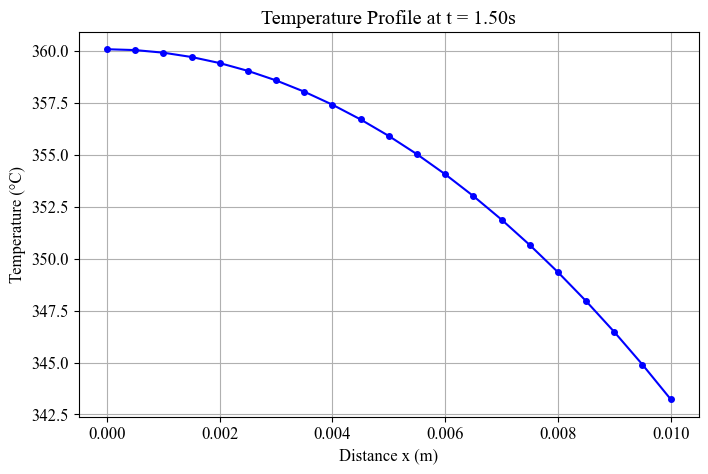

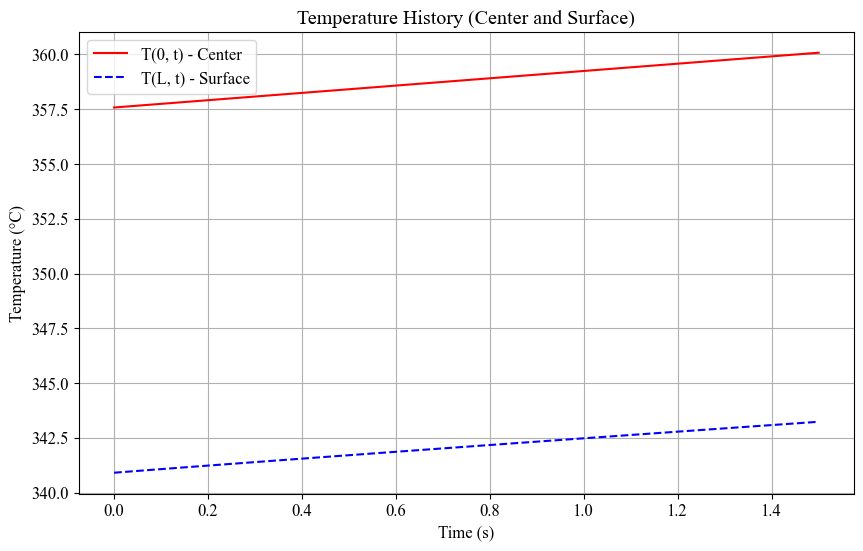

--- 绘图完成 ---


In [11]:
print("--- 正在绘制 (a) 问所需图表 ---")

# --- 图 1: T(x, 1.5s) 空间剖面图 ---
plt.figure(figsize=(8, 5))
plt.plot(x_nodes, T_current, 'b-o', markersize=4)
plt.xlabel('Distance x (m)')
plt.ylabel('Temperature (°C)')
plt.title(f'Temperature Profile at t = {t_final_actual:.2f}s')
plt.grid(True)
plt.show()

# --- 图 2: T(0, t) 和 T(L, t) 时间历史图 ---
plt.figure(figsize=(10, 6))
plt.plot(time_history, T_center_history, 'r-', label='T(0, t) - Center')
plt.plot(time_history, T_surface_history, 'b--', label='T(L, t) - Surface')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.title('Temperature History (Center and Surface)')
plt.legend()
plt.grid(True)
plt.show()

print("--- 绘图完成 ---")